# **Project Big Data with fastai**



Mounten van de google drive, het importeren van fastai en het uitpakken van de foto's gebeurd in de eerste stap.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 29.5 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 189 kB 63.7 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 324 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [8]:
!unzip data.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: data/federal/federal321.png  
  inflating: data/federal/federal322.png  
  inflating: data/federal/federal323.png  
  inflating: data/federal/federal324.png  
  inflating: data/federal/federal325.png  
  inflating: data/federal/federal326.png  
  inflating: data/federal/federal327.png  
  inflating: data/federal/federal328.png  
  inflating: data/federal/federal329.png  
  inflating: data/federal/federal33.png  
  inflating: data/federal/federal330.png  
  inflating: data/federal/federal331.png  
  inflating: data/federal/federal332.png  
  inflating: data/federal/federal333.png  
  inflating: data/federal/federal334.png  
  inflating: data/federal/federal335.png  
  inflating: data/federal/federal336.png  
  inflating: data/federal/federal337.png  
  inflating: data/federal/federal338.png  
  inflating: data/federal/federal339.png  
  inflating: data/federal/federal34.png  
  inflating: data/federal/federal340.png  
  

De volgende stap is het tonen van 1 foto om te zien of het pad goed is en de data goed geladen is.

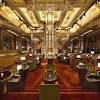

In [9]:
from PIL import Image
path = '/content/data/'
im = Image.open(path + 'art deco/art deco0.png')
im.to_thumb(128,128)

In [10]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#9053) [Path('/content/data/moorisch/moorisch311.png'),Path('/content/data/moorisch/moorisch38.png'),Path('/content/data/moorisch/moorisch14.png'),Path('/content/data/moorisch/moorisch441.png'),Path('/content/data/moorisch/moorisch268.png'),Path('/content/data/moorisch/moorisch135.png'),Path('/content/data/moorisch/moorisch415.png'),Path('/content/data/moorisch/moorisch306.png'),Path('/content/data/moorisch/moorisch271.png'),Path('/content/data/moorisch/moorisch204.png')...]

Nadien kijken we na of er geen corrupte files tussen staan

In [11]:
failed = verify_images(filenames)
failed

(#0) []

# **Fastai data block API**


Als volgend maken we een data block aan waarin we de data splitsen tussen volidatie en test en random resizen voor een groter aantal foto's.

In [12]:
architecture = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [13]:
dls = architecture.dataloaders(path)

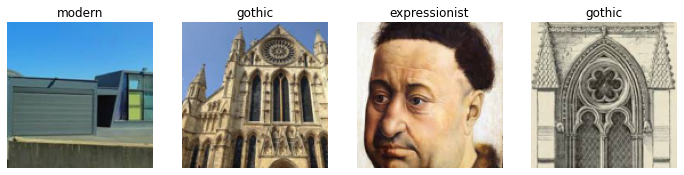

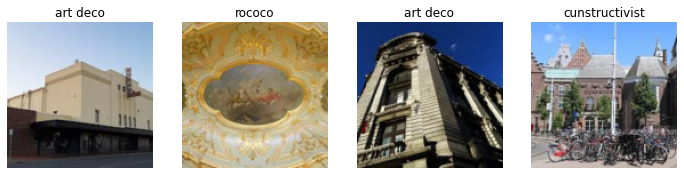

In [14]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

Tonen van 8 foto's 4 per row die geresized zijn

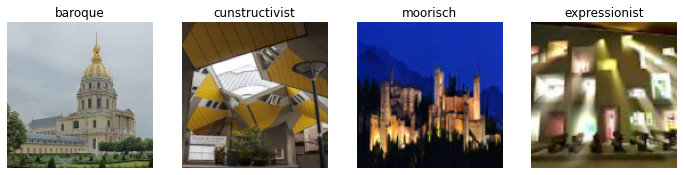

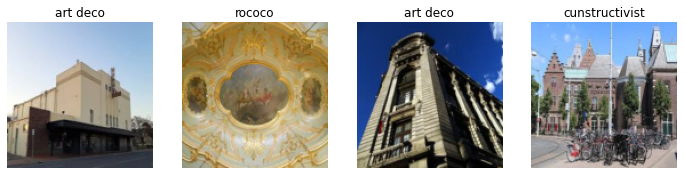

In [15]:
architecture = architecture.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

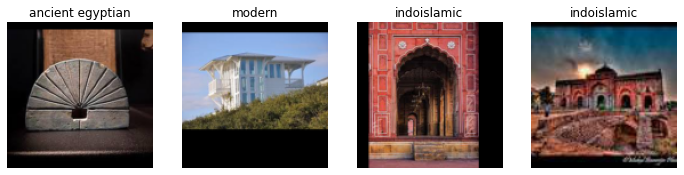

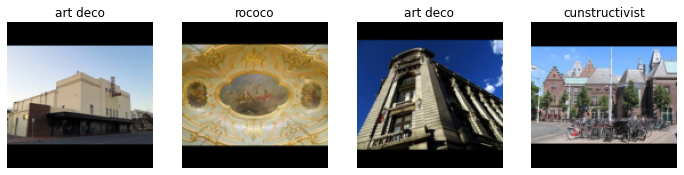

In [16]:
architecture = architecture.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

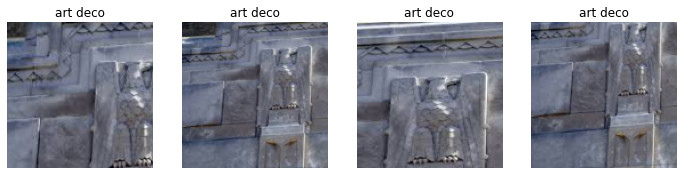

In [17]:
architecture = architecture.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = architecture.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)
# the unique=True piece here is just to force our sanity check to give us the same image over and over again, 
# ofcourse each time with the random transform applied to it

Het trainen van het model kan eindelijk gebeuren. We hebben gekozen voor maar 3 epochs aangezien vanaf 4 epochs de data biased werd.

In [18]:
our_out_of_the_box_model = cnn_learner(dls, resnet50, metrics=error_rate)
our_out_of_the_box_model.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

epoch,train_loss,valid_loss,error_rate,time


Nu we getraind hebben kijken we naar de confussionmatrix om te zien waar het goed en slecht gaat met categoriseren.

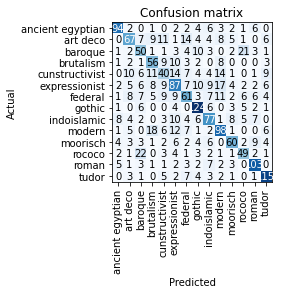

In [19]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Google teachable machine verwarringsmatrix 


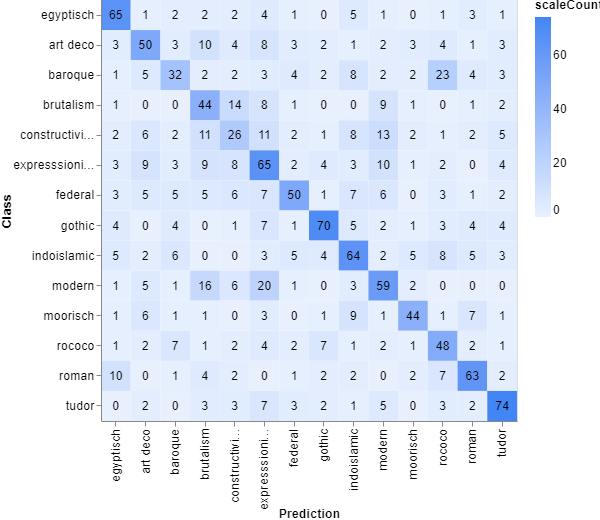

We tonen van alle foto's de top 10 waarbij de error het grootste is.

In [20]:
#interp.plot_top_losses(2, nrows=1)

def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)



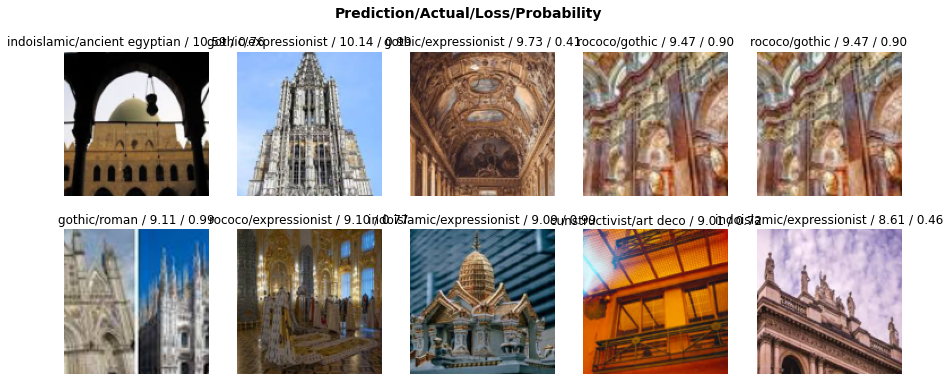

In [21]:
plot_top_losses_fix(interp, 10, nrows=2)

In [22]:
# saving our model, by default in a folder called 'models'.
our_out_of_the_box_model.save('good_model')
#creating an serialized pickle object of our model, the export.pkl file
our_out_of_the_box_model.export()

In [22]:
ls

data/  data.zip  export.pkl  gdrive/  models/  sample_data/


# **laden van het model en uitproberen met foto**

We halen de .pkl file op en voorspellen het resultaat vanuit de opgeladen export file.

In [24]:
our_out_of_the_box_model_inference = load_learner('export.pkl')
# let's test our model on an image
our_out_of_the_box_model_inference.predict('/content/data/modern/modern101.png')
# this will return the predicted category, the index of this predicted category, and the probabilities of each category

('expressionist',
 TensorBase(5),
 TensorBase([4.7753e-03, 2.5152e-02, 5.1793e-04, 4.0738e-02, 4.2338e-03, 6.1465e-01, 4.5408e-02, 2.2867e-03, 9.1173e-03, 2.5046e-01, 6.2986e-04, 5.1209e-04, 1.3096e-03, 2.1098e-04]))

In [ ]:
our_out_of_the_box_model_inference.dls.vocab

________________________________________________________________________________________________________________________________________________________________
# **Deel 2 : Advanced ai training**

Terug de basis imports doen en het opladen vanuit de zip file.

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 189 kB 45.7 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 1.2 MB 36.0 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 286 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
!unzip data.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: data/federal/federal321.png  
  inflating: data/federal/federal322.png  
  inflating: data/federal/federal323.png  
  inflating: data/federal/federal324.png  
  inflating: data/federal/federal325.png  
  inflating: data/federal/federal326.png  
  inflating: data/federal/federal327.png  
  inflating: data/federal/federal328.png  
  inflating: data/federal/federal329.png  
  inflating: data/federal/federal33.png  
  inflating: data/federal/federal330.png  
  inflating: data/federal/federal331.png  
  inflating: data/federal/federal332.png  
  inflating: data/federal/federal333.png  
  inflating: data/federal/federal334.png  
  inflating: data/federal/federal335.png  
  inflating: data/federal/federal336.png  
  inflating: data/federal/federal337.png  
  inflating: data/federal/federal338.png  
  inflating: data/federal/federal339.png  
  inflating: data/federal/federal34.png  
  inflating: data/federal/federal340.png  
  

We maken een nieuwe datablok aan met resizing en transforming

In [10]:
Gebouwen = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
     
    get_y=parent_label,
     
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

In [11]:
path = '/content/data/'
dls = Gebouwen.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


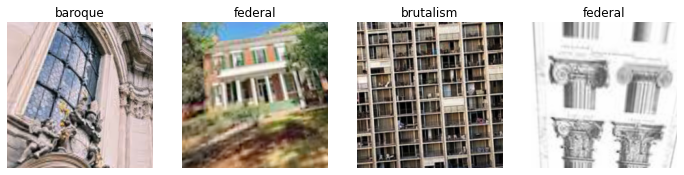

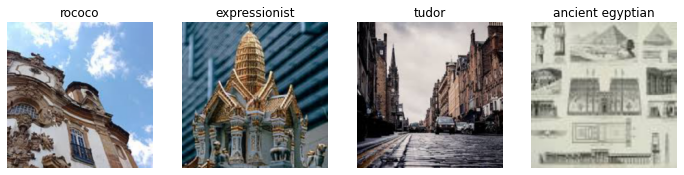

In [12]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

#**Training via het alexnet model.**

AlexNet contained eight layers; the first five were convolutional layers, some of them followed by max-pooling layers, and the last three were fully connected layers. It used the non-saturating ReLU activation function, which showed improved training performance over tanh and sigmoid

In [13]:
alex_model = cnn_learner(dls, alexnet, metrics=error_rate)
alex_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.805020,1.933728,0.581768,01:06


epoch,train_loss,valid_loss,error_rate,time
0,2.210030,1.709460,0.538122,01:11


# **Training via vgg16 model**

Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2

In [14]:
vgg16_model = cnn_learner(dls, vgg16_bn, metrics=error_rate)
vgg16_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.674296,1.756594,0.514917,07:04


epoch,train_loss,valid_loss,error_rate,time
0,1.863627,1.471575,0.448619,09:51


# **Resnet model**

ResNet first introduced the concept of skip connection.
we still stack convolution layers as before but we now also add the original input to the output of the convolution block. This is called skip connection

In [15]:
resnet50_model = cnn_learner(dls, resnet50, metrics=error_rate)
resnet50_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.472112,1.844266,0.517127,03:08


epoch,train_loss,valid_loss,error_rate,time
0,1.725762,1.401489,0.427624,04:01


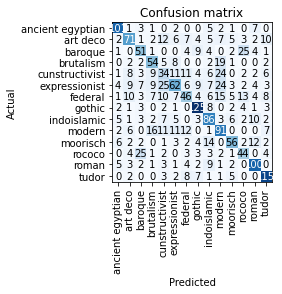

In [16]:
interp = ClassificationInterpretation.from_learner(resnet50_model)
interp.plot_confusion_matrix()

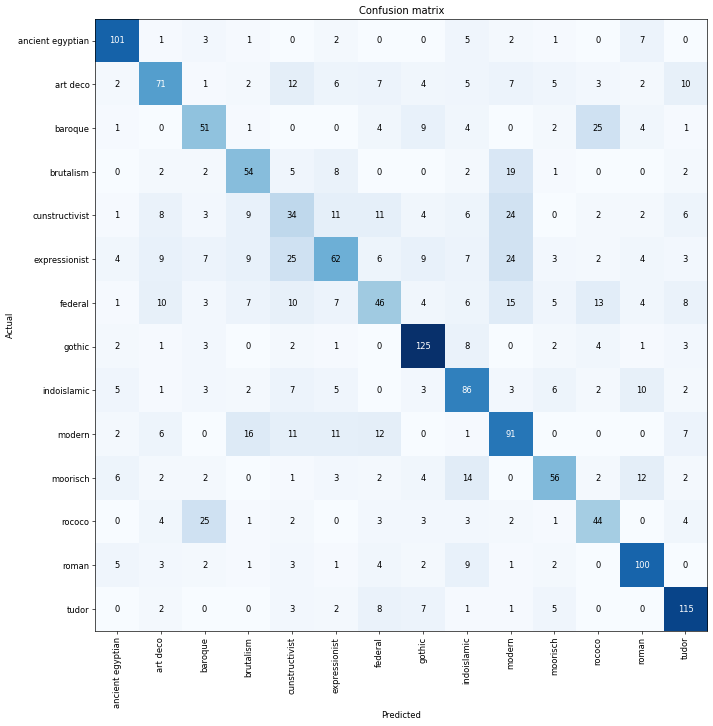

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

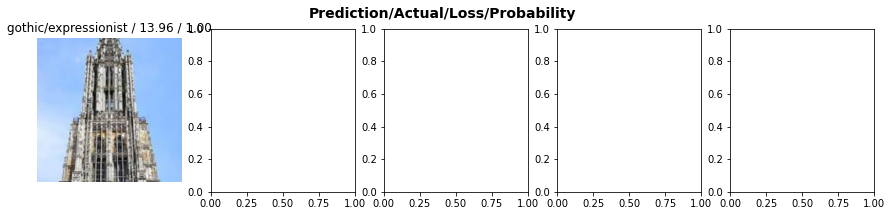

In [18]:
interp.plot_top_losses(5, nrows=1)

In [19]:
interp.most_confused(min_val=5)

[('baroque', 'rococo', 25),
 ('expressionist', 'cunstructivist', 25),
 ('rococo', 'baroque', 25),
 ('cunstructivist', 'modern', 24),
 ('expressionist', 'modern', 24),
 ('brutalism', 'modern', 19),
 ('modern', 'brutalism', 16),
 ('federal', 'modern', 15),
 ('moorisch', 'indoislamic', 14),
 ('federal', 'rococo', 13),
 ('art deco', 'cunstructivist', 12),
 ('modern', 'federal', 12),
 ('moorisch', 'roman', 12),
 ('cunstructivist', 'expressionist', 11),
 ('cunstructivist', 'federal', 11),
 ('modern', 'cunstructivist', 11),
 ('modern', 'expressionist', 11),
 ('art deco', 'tudor', 10),
 ('federal', 'art deco', 10),
 ('federal', 'cunstructivist', 10),
 ('indoislamic', 'roman', 10),
 ('baroque', 'gothic', 9),
 ('cunstructivist', 'brutalism', 9),
 ('expressionist', 'art deco', 9),
 ('expressionist', 'brutalism', 9),
 ('expressionist', 'gothic', 9),
 ('roman', 'indoislamic', 9),
 ('brutalism', 'expressionist', 8),
 ('cunstructivist', 'art deco', 8),
 ('federal', 'tudor', 8),
 ('gothic', 'indoislam

In [20]:
resnet34_overtrain = cnn_learner(dls, resnet34, metrics=error_rate)
resnet34_overtrain.fine_tune(1, base_lr=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.770360,2.862664,0.675691,02:14


epoch,train_loss,valid_loss,error_rate,time
0,2.371486,1.996122,0.666851,02:58


In [23]:
resnet_adv = cnn_learner(dls, resnet34, metrics=error_rate)
resnet_adv.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.437516,1.715741,0.524862,02:15
1,1.795231,1.398267,0.445304,02:15
2,1.446647,1.335266,0.426519,02:15


**What is model freezing?**
Freezing the model means producing a singular file containing information about the graph and checkpoint variables, but saving these hyperparameters as constants within the graph structure. ... A frozen model is a file of the Google .

In [24]:
resnet_adv.unfreeze()

SuggestedLRs(valley=6.918309736647643e-06)

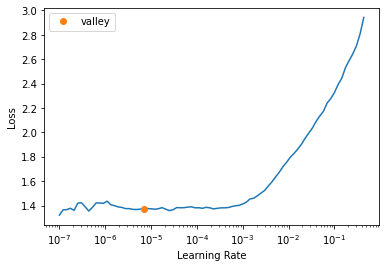

In [25]:
resnet_adv.lr_find()

In [26]:
resnet_adv.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.347293,1.317582,0.426519,02:58
1,1.307090,1.291218,0.417680,02:58
2,1.233766,1.257759,0.403867,02:59
3,1.197929,1.252270,0.404420,02:58
4,1.155953,1.242715,0.397238,02:58
5,1.140114,1.243137,0.399448,02:58


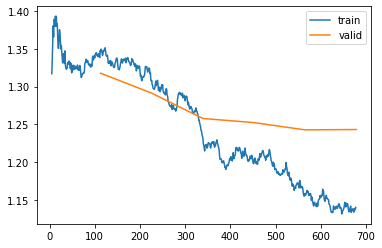

In [27]:
resnet_adv.recorder.plot_loss()

In [28]:
resnet_really_adv = cnn_learner(dls, resnet34, metrics=error_rate)
resnet_really_adv.fit_one_cycle(3, 3e-3)
resnet_really_adv.unfreeze()
resnet_really_adv.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,2.513052,1.757048,0.529834,02:15
1,1.806646,1.416206,0.450276,02:15
2,1.482229,1.352025,0.431492,02:15


epoch,train_loss,valid_loss,error_rate,time
0,1.363296,1.339695,0.425414,02:59
1,1.334887,1.314745,0.422099,02:58
2,1.276881,1.293794,0.412707,02:59
3,1.229483,1.270540,0.399448,02:59
4,1.163592,1.255766,0.401105,02:59
5,1.114536,1.233230,0.400000,02:58
6,1.074935,1.237986,0.396133,02:59
7,1.008424,1.218419,0.387293,02:59
8,0.966141,1.223673,0.385635,02:59
9,0.958188,1.211301,0.386188,02:58


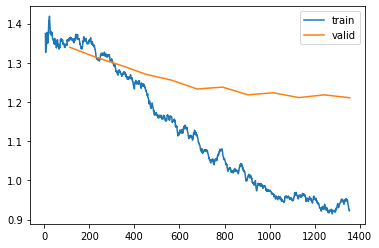

In [29]:
resnet_really_adv.recorder.plot_loss()

In [30]:
from fastai.callback.fp16 import *
resnet_adv_tweaked = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
resnet_adv_tweaked.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,2.636188,1.790179,0.516575,02:49
1,2.122864,1.683197,0.476796,02:49
2,1.761852,1.465484,0.447514,02:49


epoch,train_loss,valid_loss,error_rate,time
0,1.366812,1.381606,0.411050,03:45
1,1.273490,1.345081,0.403867,03:44
2,1.041093,1.239144,0.366851,03:45
3,0.715665,1.202735,0.344751,03:44
4,0.473628,1.200704,0.336464,03:45
5,0.333806,1.200814,0.330387,03:45


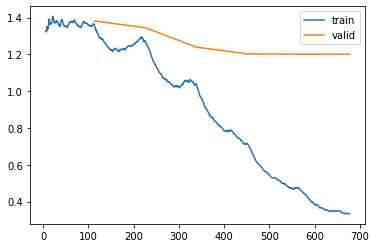

In [31]:
resnet_adv_tweaked.recorder.plot_loss()

In [33]:
resnet_really_adv.export()